In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
system = 'cartesius'
df = pd.read_parquet(f'data/mpi/{system}/{system}_interval.gzip')

In [3]:
# select configurations

def configurations_cartesius():
    '''
    Return a generator of all the configurations. Each configuration is a list of strings.
    '''
    network_backend = ['ib']
    profile_level = ['tau_exec']
    workers = [2, 8]
    neural_network = ['resnet50']
    data_loader = ['dali-gpu', 'dali-cpu-to-gpu']
    batch_size_per_gpu = [32, 64]
    grad_precision = ['fp16', 'fp32']
    compute_precision = ['fp32']
    
    def to_str(l):
        return [str(elem) for elem in l]

    confs = [
            network_backend,
            profile_level,
            to_str(workers),
            neural_network,
            data_loader,
            to_str(batch_size_per_gpu),
            grad_precision,
            compute_precision
            ]
    
    return itertools.product(*confs)

In [4]:
# select configurations

def configurations_lisa():
    '''
    Return a generator of all the configurations. Each configuration is a list of strings.
    '''
    network_backend = ['eth']
    profile_level = ['tau_exec']
    workers = [2, 4]
    neural_network = ['resnet50']
    data_loader = ['dali-gpu', 'dali-cpu-to-gpu']
    batch_size_per_gpu = [32, 64]
    grad_precision = ['fp16', 'fp32']
    compute_precision = ['fp32']
    
    def to_str(l):
        return [str(elem) for elem in l]

    confs = [
            network_backend,
            profile_level,
            to_str(workers),
            neural_network,
            data_loader,
            to_str(batch_size_per_gpu),
            grad_precision,
            compute_precision
            ]
    
    return itertools.product(*confs)

In [5]:
nodes = [8, 16, 32, 48] if system == 'cartesius' else [1, 4, 8]

data = dict()

confs = configurations_cartesius() if system == 'cartesius' else configurations_lisa()
for conf in confs:
    backend, profile, workers, nn, dataloader, batch_size, grad, comp = conf
    durations_per_gpu = []
    gpus = []
    for node in nodes:
        if system == 'cartesius':
            gpus_per_node = [2] if node != 1 else [1, 2]
        else:
            gpus_per_node = [4] if node != 1 else [4]

        for gpu in gpus_per_node:
            df_conf = df[
                (df['network_backend']==backend) &
                (df['profile_level']==profile) &
                (df['workers']==int(workers)) &
                (df['neural_network']==nn) &
                (df['data_loader']==dataloader) &
                (df['batch_size_per_gpu']==int(batch_size)) &
                (df['grad_precision']==grad) &
                (df['compute_precision']==comp) &
                (df['nodes']==node) &
                (df['function']=='.tau application')
            ]    

            total_gpus = node * gpu
            gpus.append(total_gpus)
            # get duration
            durations = df_conf.groupby('run').max().inc_time.values
            median_duration = np.median(durations) * 1E-6 # in seconds
            durations_per_gpu.append(median_duration)
    data[conf] = (gpus, durations_per_gpu)


# Scaling efficiency

In [6]:
def median_duration_epoch(df, node, gpus_per_node, batch_size, init_time):
    '''
    Return the median duration of 1 epoch for the 10 runs of the experiment
    '''
    durations_epoch = []
                
    total_img_processed = node * int(gpus_per_node) * int(batch_size) * 50
    for run in range(10):

        duration = df[
            (df['gpus_per_node'] == int(gpus_per_node)) & 
            (df['nodes'] == node) & 
            (df['run'] == run)
        ]['inc_time']

        duration = np.max(duration) * 1E-6 # convert to seconds
        duration -= init_time # substract initialization time
        duration_epoch = duration * 1E6 / total_img_processed # 1 million images per epoch

        durations_epoch.append(duration_epoch)

    data = np.array(durations_epoch)
    durations_epoch = data[abs(data - np.mean(data)) < 2 * np.std(data)]
    median_duration_epoch = np.median(durations_epoch)
    return median_duration_epoch

In [7]:
def scaling_efficiencies(d):
    '''
    Return 2 lists:
    - all the numbers of GPUs used
    - the scaling efficiency for the corresponding number of GPUs
    '''
    gpus = []
    efficiencies = []
    for gpu, t in d.items():
        if system == 'cartesius':
            efficiencies.append(d[16] / (gpu * t/16)*100)
        else:
            efficiencies.append(d[4] / (gpu * t/4)*100)
        gpus.append(gpu)
    return gpus, efficiencies

In [8]:
nodes = [8, 16, 32, 48] if system == 'cartesius' else [1, 4, 8]
confs = configurations_cartesius() if system == 'cartesius' else configurations_lisa()

data_efficiency = dict()
for i, conf in enumerate(confs):
    
    network_backend, profile_level, workers, nn, data_loader, batch_size, grad, compute = conf
    
    mask_config = \
        (df['network_backend'] == network_backend) & \
        (df['profile_level'] == profile_level) & \
        (df['workers'] == int(workers)) & \
        (df['neural_network'] == nn) & \
        (df['data_loader'] == data_loader) & \
        (df['batch_size_per_gpu'] == int(batch_size)) & \
        (df['grad_precision'] == grad) & \
        (df['compute_precision'] == compute) & \
        (df['function'] == '.tau application')
    
    df_config = df[mask_config]
    
    d = {} # map number of GPUs to the duration of 1 epoch
    
    for node in nodes:
            gpus_per_node = 2 if system == 'cartesius' else 4
            d[node * gpus_per_node] = median_duration_epoch(df_config, node, gpus_per_node, batch_size, 0)
    
    gpus, efficiencies = scaling_efficiencies(d)
    data_efficiency[conf] = (gpus, efficiencies)


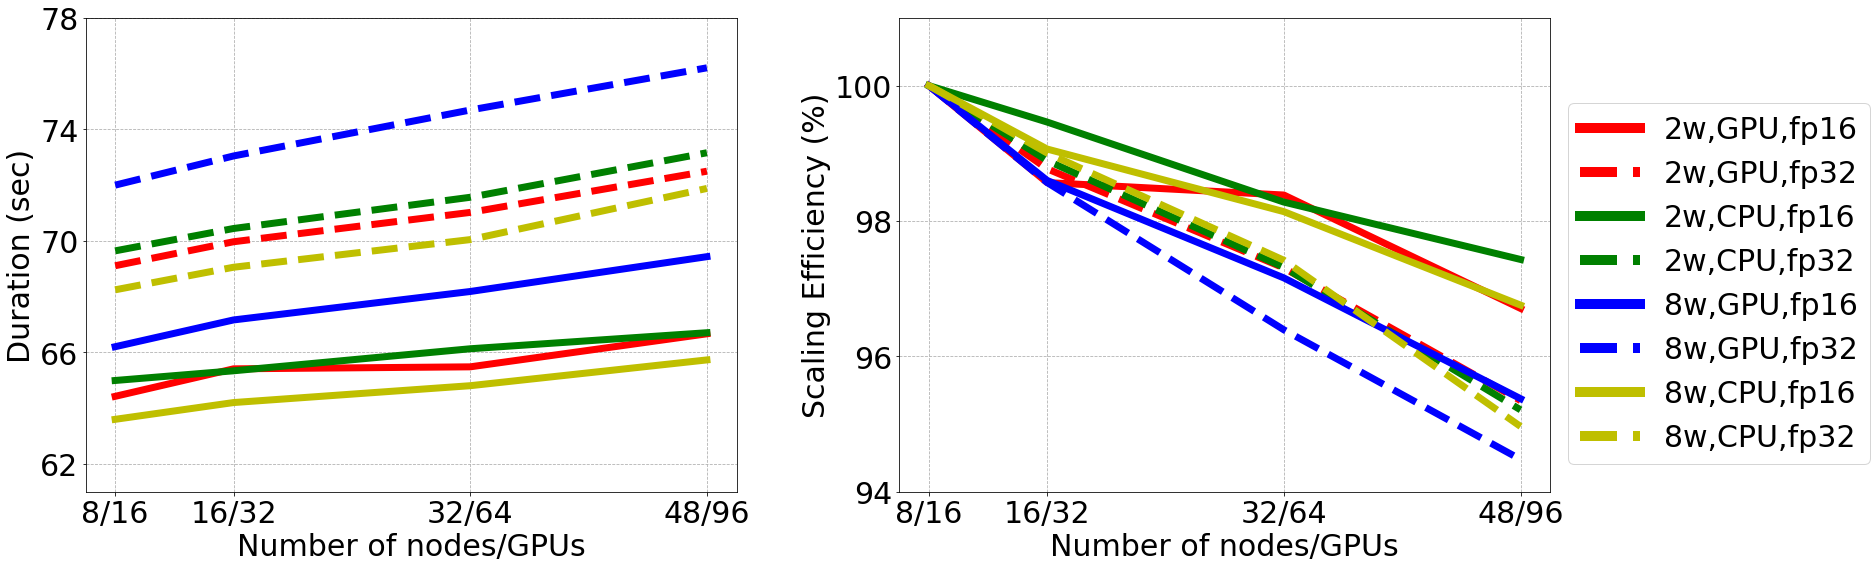

In [9]:
from cycler import cycler
default_cycler = (cycler(color=['r', 'g', 'b', 'y']) *
                  cycler(linestyle=['-', '--']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26,8))


# DURATION
ax1.set_prop_cycle(default_cycler)
ax1.tick_params(axis='both', labelsize=30)

confs = configurations_cartesius() if system == 'cartesius' else configurations_lisa()
for conf in confs:
    backend, profile, workers, nn, dataloader, batch_size, grad, comp = conf
    if int(batch_size) == 64: continue
    gpus, durations = data[conf]
    ax1.plot(gpus, 
            durations, 
            linewidth=7, 
            label=f"{workers}w,{'CPU' if dataloader=='dali-cpu-to-gpu' else 'GPU'},{grad}",
           )


ax1.set_xticks(gpus)
ax1.set_xticklabels([f"{gpu//2}/{gpu}" if system == 'cartesius' else f"{gpu//4}/{gpu}" for gpu in gpus])
ax1.set_ylim(61, 78)
ax1.set_yticks([62, 66, 70, 74, 78])


ax1.set_xlabel('Number of nodes/GPUs', fontsize=30)
ax1.set_ylabel('Duration (sec)', fontsize=30)
ax1.grid(linestyle='--')


# SCALING EFFICIENCY
ax2.set_prop_cycle(default_cycler)
ax2.tick_params(axis='both', labelsize=30)

confs = configurations_cartesius() if system == 'cartesius' else configurations_lisa()
for conf in confs:
    backend, profile, workers, nn, dataloader, batch_size, grad, comp = conf
    if int(batch_size) == 64: continue
    gpus, durations = data_efficiency[conf]
    ax2.plot(gpus, 
            durations, 
            linewidth=7, 
           )

ax2.set_xticks(gpus)
ax2.set_xticklabels([f"{gpu//2}/{gpu}" if system == 'cartesius' else f"{gpu//4}/{gpu}" for gpu in gpus])
ax2.set_ylim(94, 101)
ax2.set_yticks([94, 96, 98, 100])


ax2.set_xlabel('Number of nodes/GPUs', fontsize=30)
ax2.set_ylabel('Scaling Efficiency (%)', fontsize=30)
ax2.grid(linestyle='--')



# Put a legend to the right of the current axis
l = fig.legend(loc='center right',  borderaxespad=0.1, fontsize=30)
for line in l.get_lines():
    line.set_linewidth(10.0)

plt.tight_layout()
plt.subplots_adjust(right=0.83, wspace=0.25)